In [1]:
using Random
using Statistics
using DataFrames
using CSV
using Plots
using JuMP, Gurobi
using GLMNet
using MLBase
using Pkg
using Distributions
using HMMBase
using BenchmarkTools

## Generate synthetic dataset with following characteristics

1. S=10 number of states
2. Emmission probabilities are normal distributions with k*i as mean and standard deviation=1 - These are known and we are not estimating them
3. Inital probability vector which is generated randomly
    4. This is to be estimated
4. State transition matrix generated randomly 
    5. This is to be estimated    

In [2]:
Random.seed!(15095)

MersenneTwister(15095)

In [3]:
## Define size of problem 

m = 10 ; #Number of states

In [4]:
# Define Initial probabilities matrix
pi_true = rand(Float64, m) ; 
pi_true = (pi_true)./(sum(pi_true)) ;  # So that initial probabilities sum to 1

#Define State transition probabilities

A_true = rand(Float64, (m,m)) ; 
for i =1:m
   A_true[i,:]  = A_true[i,:]/(sum(A_true[i,:])) ;
end

In [5]:
println("Initial probabilities: ")
pi_true

Initial probabilities: 


10-element Vector{Float64}:
 0.07486090994046252
 0.06630907995099644
 0.04635497490858906
 0.12989977210234596
 0.07946431674890926
 0.007701590683127249
 0.03216603198044118
 0.22843504422317773
 0.2659854323941368
 0.06882284706781369

In [6]:
println("State transition probabilities: ")
A_true

State transition probabilities: 


10×10 Matrix{Float64}:
 0.0752931   0.1341      0.0197698  …  0.0199917  0.116939   0.131136
 0.0850281   0.00812193  0.110777      0.140611   0.160813   0.102774
 0.118604    0.0305247   0.0441062     0.0406136  0.0577275  0.11217
 0.00860176  0.133947    0.124884      0.13774    0.108742   0.0446017
 0.114674    0.100397    0.0918971     0.131533   0.127359   0.0111749
 0.03043     0.148723    0.100613   …  0.0977629  0.14696    0.0136002
 0.0678053   0.0963498   0.161962      0.0260425  0.137581   0.0375044
 0.184826    0.00294772  0.125397      0.194892   0.0573867  0.0430482
 0.135083    0.00606615  0.176531      0.0378103  0.0582549  0.194518
 0.105152    0.0999984   0.0828344     0.0766694  0.173632   0.148507

### Generate Synthetic dataset

1. First working with 1-D Gaussian
2. This dataset is clean, without any noise!

In [9]:
k = 2 ;

emission_dists = [Normal(0,1) , Normal(1*k,1) , Normal(2*k,1), Normal(3*k,1), Normal(4*k,1)
                , Normal(5*k,1), Normal(6*k,1), Normal(7*k,1), Normal(8*k,1), Normal(9*k,1) ] ; 

In [10]:
emission_dists

10-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=0.0, σ=1.0)
 Normal{Float64}(μ=2.0, σ=1.0)
 Normal{Float64}(μ=4.0, σ=1.0)
 Normal{Float64}(μ=6.0, σ=1.0)
 Normal{Float64}(μ=8.0, σ=1.0)
 Normal{Float64}(μ=10.0, σ=1.0)
 Normal{Float64}(μ=12.0, σ=1.0)
 Normal{Float64}(μ=14.0, σ=1.0)
 Normal{Float64}(μ=16.0, σ=1.0)
 Normal{Float64}(μ=18.0, σ=1.0)

In [12]:
hmm = HMM(pi_true , A_true, emission_dists) ; 

In [223]:
## Generate one sequence of 1000 timesteps
S, X = rand(hmm, 5000, seq = true) ; 

We know the true states as well as the observed data. 
Going forward, for the parameter estimation we will use only X. We swill use S later once we decode the HMM using our estimated params

## Implement Robust EM algorithm

In [7]:
## Initialize guesses

pi_init = rand(Float64, m) ;  
pi_init = (pi_init)./(sum(pi_init)) ;  # So that initial probabilities sum to 1


#Define State transition probabilities

A_init = rand(Float64, (m,m)) ; 
for i =1:m
   A_init[i,:]  = A_init[i,:]/(sum(A_init[i,:])) ;
end


#Initial guess for robust delta(X)
delta_X_init = zeros(size(X)) ; 

LoadError: UndefVarError: X not defined

In [8]:
## Define hyperparameters for algo

r = 0.05 ; # Radius of uncertainty set to be used
num_iters = 100 ; 

## Robust EM - Algorithm for 1-D Gaussian Emission distribution and will train on only one sequence

In [226]:
## Start EM algorithm

pi_current = pi_init ; 
A_current = A_init ; 
delta_X_current = delta_X_init ; 


ll_tracker = [] ; 

for iter=1:num_iters
    
    if (iter%10==0)
        print("Running iteration number: ") ; 
        println(iter) ; 
    end
    
    ## E-step - Compute α and β given current pi, A and delta_X
    
    # For current iteration define HMM with current guesses of pi, A and delta_X 
    
    # Emission distribution is assumed to be known
    hmm_current = HMM(pi_current , A_current, emission_dists) ; 
    
    # Using current estimate of worst possible delta_X to get α and β

    alpha_current, ll = forward(hmm_current, (X+delta_X_current)) ;
    beta_current, ll = backward(hmm_current, (X+delta_X_current)) ;
    
    ## Multiply in sigma and -1 for ease in later computations
    
    alpha_sigma_current = zeros(size(alpha_current)) ; 
    for i=1:m
         alpha_sigma_current[:,i] = -(alpha_current[:,i])/(2*(emission_dists[i].σ)^2) ; 
    end

    
    
    ##Track log-likelihood - of current parameters guess with the actual data 
    alp_discard, ll_tr = forward(hmm_current, (X) ) ;
    append!(ll_tracker, ll_tr) ; 
    print("Current log-likelihood: ") ; 
    println(ll_tr) ; 
       
    ## M-step 1: Solve inner minimization problem to get best value of delta_X
    
    # Build model
    model = Model(Gurobi.Optimizer) ; 
    set_optimizer_attribute(model, "OutputFlag", 0) ;

    # Insert variables

    #delta_x variables
    @variable(model,delta_X[t=1:size(X,1)]) ; # If multivariate change this line
    @variable(model,diff[t=1:size(X,1), i=1:m]) ;  # If multivariate change this line

    #Insert constraints - For 1-D it is the same to use 1-norm or 2-norm will use linear constraints
    
    @constraint(model,[i=1:size(X,1)], delta_X[i] <= r ) ;
    @constraint(model,[i=1:size(X,1)], delta_X[i] >= -r ) ;
    @constraint(model,[t=1:size(X,1), i=1:m], diff[t,i] == (X[t] + delta_X[t] - emission_dists[i].μ )) ;
    

    #Objective
    @objective(model,Max, sum(alpha_sigma_current.*beta_current.*(diff.^2))) ;

    # Optimize
    optimize!(model)
    
    println("MOdel optimization done!")
    delta_X_current = value.(delta_X) ; 
    
    
    ## M-step 2: Replace X by X+delta_X_current - Solve for pi_new, A_new
    
    ## Re-compute α and β based on new delta? Not sure if to do or not - Can try both and 
    #see which gives good results
    
    alpha_current, ll = forward(hmm_current, (X+delta_X_current)) ;
    beta_current, ll = backward(hmm_current, (X+delta_X_current)) ;

    ## Define new quantities γ_ij(t) and ξ_ij(t)
    
    gamma_current = zeros((size(X,1), m)) ; ## Indexed as γ[t,i]
    eta_current = zeros((size(X,1)-1, m, m)) ;  # Indexed as ξ[t,i,j]
    
    # Fill in gamma vals
    gamma_current = alpha_current.*beta_current ; 
    
    for t=1:size(X,1)        
        gamma_current[t, :] = gamma_current[t, :]./(sum(gamma_current[t, :])) ;             
    end
    
    ## FIll in ξ values 
    
#     for i=1:m
#         for j=1:m
#             for t=1:(size(X,1)-1)
            
#                 eta_current[t,i,j] = (gamma_current[t,i]*A_current[i,j]*
#                     (pdf(emission_dists[j], ((X+delta_X_current)[t+1])))*beta_current[t+1,j])/(beta_current[t,i]) ;
            
#             end
#         end
#     end
    
    
    for i=1:m
        for j=1:m
            for t=1:size(X,1)-1
                eta_current[t,i,j] = alpha_current[t,i]*A_current[i,j]*(pdf(emission_dists[j], ((X+delta_X_current)[t+1])))*beta_current[t+1,j]
            end
        end
    end
    
    for t=1:size(X,1)-1
         eta_current[t,:,:] = eta_current[t,:,:]/sum(eta_current[t,:,:])  ;  
    end
    
    
#     println("Computed necessary vals")
#     println(size(eta_current))
    
    ## Update parameter values 
    
    pi_next = gamma_current[1, :]  ; 
    A_next = zeros(size(A_init)) ; 
    
    for i=1:m
        for j=1:m        
            A_next[i,j] = sum(eta_current[:,i,j])/sum(gamma_current[1:size(X,1)-1,i]) ;                      
        end
    end
    
            
    
    

    pi_current = pi_next ; 
    A_current = A_next ; 
    
#     println("One loop over")
    
end

Current log-likelihood: -15582.852923270257
Academic license - for non-commercial use only - expires 2022-09-11
MOdel optimization done!
Current log-likelihood: -15205.925717484603
Academic license - for non-commercial use only - expires 2022-09-11
MOdel optimization done!
Current log-likelihood: -15123.42670425072
Academic license - for non-commercial use only - expires 2022-09-11
MOdel optimization done!
Current log-likelihood: -15088.16079818767
Academic license - for non-commercial use only - expires 2022-09-11
MOdel optimization done!
Current log-likelihood: -15068.912722843
Academic license - for non-commercial use only - expires 2022-09-11
MOdel optimization done!


LoadError: InterruptException:

## Robust EM - Algorithm for 1-D Gaussian Emission distribution and will train on multiple sequences

1. What changes? 
2. sum objective function over all the sequences
3. See update rule accordingly

(20, 1000)

#### Generate multiple sequences

In [13]:
## Generate one sequence of 1000 timesteps
seq_length = 1000 ; 
num_sequences = 20 ; 


S = zeros((num_sequences, seq_length)) ; 
X = zeros((num_sequences, seq_length)) ; 

for i =1:num_sequences
    S[i,:] , X[i,:] = rand(hmm, seq_length, seq = true) ; 
end


In [14]:
## Initialize guesses

pi_init = rand(Float64, m) ;  
pi_init = (pi_init)./(sum(pi_init)) ;  # So that initial probabilities sum to 1


#Define State transition probabilities

A_init = rand(Float64, (m,m)) ; 
for i =1:m
   A_init[i,:]  = A_init[i,:]/(sum(A_init[i,:])) ;
end


#Initial guess for robust delta(X)
delta_X_init = zeros(size(X)) ; 

X indexed as X[seq_num , t]

In [15]:
## Define hyperparameters for algo

r = 0.05 ; # Radius of uncertainty set to be used
num_iters = 100 ; 

In [234]:
## Start EM algorithm for multiple sequence training

pi_current = pi_init ; 
A_current = A_init ; 
delta_X_current = delta_X_init ; 


ll_tracker = [] ; 

for iter=1:num_iters
    
    if (iter%10==0)
        print("Running iteration number: ") ; 
        println(iter) ; 
    end
    
    ## E-step - Compute α and β given current pi, A and delta_X
    
    # For current iteration define HMM with current guesses of pi, A and delta_X 
    
    # Emission distribution is assumed to be known
    hmm_current = HMM(pi_current , A_current, emission_dists) ; 
    
    # Using current estimate of worst possible delta_X to get α and β

    alpha_current = zeros((size(X,1) , size(X,2), m)) ;  #alpha indexed as alpha[seq_num,t,i]
    beta_current = zeros((size(X,1) , size(X,2), m)) ;  #beta[seq_num,t,i]
    
    
    # Run forward-backward algorithm on all the sequences
    for seq_num=1:size(X,1)    
        alpha_current[seq_num,:,:], ll = forward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
        beta_current[seq_num,:,:], ll = backward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
    end
    
    
    ## Multiply in sigma and -1 for ease in later computations
    
    alpha_sigma_current = zeros(size(alpha_current)) ; 
    for i=1:m
         alpha_sigma_current[:,:,i] = -(alpha_current[:,:,i])/(2*(emission_dists[i].σ)^2) ; 
    end

    
    ##Track log-likelihood - of current parameters guess with the actual data 
    
    ll_tr = 0 
    for seq_num=1:size(X,1)
        alp_discard, ll_temp = forward(hmm_current, (X[seq_num,:]) ) ;
        ll_tr = ll_tr + ll_temp
    end
    
    ll_tr = (1/size(X,1))*ll_tr ; 
    
    
    append!(ll_tracker, ll_tr) ; 
    print("Current log-likelihood: ") ; 
    println(ll_tr) ; 
       
    ## M-step 1: Solve inner minimization problem to get best value of delta_X
    ## Do this by solving minimization problem for each sequence one after another - It's the same thing for 
    ## Each sequence and they do no interact in any way!
    for seq_num=1:size(X,1)
        
        # Build model
        model = Model(Gurobi.Optimizer) ; 
        set_optimizer_attribute(model, "OutputFlag", 0) ;

        # Insert variables

        #delta_x variables
        @variable(model,delta_X[t=1:size(X,2)]) ; # If multivariate change this line
        @variable(model,diff[t=1:size(X,2), i=1:m]) ;  # If multivariate change this line

        #Insert constraints - For 1-D it is the same to use 1-norm or 2-norm will use linear constraints

        @constraint(model,[i=1:size(X,2)], delta_X[i] <= r ) ;
        @constraint(model,[i=1:size(X,2)], delta_X[i] >= -r ) ;
        @constraint(model,[t=1:size(X,2), i=1:m], diff[t,i] == (X[seq_num, t] + delta_X[t] - emission_dists[i].μ )) ;


        #Objective
        @objective(model,Max, sum(alpha_sigma_current[seq_num,:,:].*beta_current[seq_num,:,:].*(diff.^2))) ;

        # Optimize
        optimize!(model)
        
        delta_X_current[seq_num, :] = value.(delta_X) ;       
    end
    
    println("Model optimization done!")
     
    
    
    ## M-step 2: Replace X by X+delta_X_current - Solve for pi_new, A_new
    
    ## Re-compute α and β based on new delta? Not sure if to do or not - Can try both and 
    #see which gives good results
    
    alpha_current = zeros((size(X,1) , size(X,2), m)) ;  #alpha indexed as alpha[seq_num,t,i]
    beta_current = zeros((size(X,1) , size(X,2), m)) ;  #beta[seq_num,t,i]
       
    # Run forward-backward algorithm on all the sequences
    for seq_num=1:size(X,1)    
        alpha_current[seq_num,:,:], ll = forward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
        beta_current[seq_num,:,:], ll = backward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
    end


    ## Define new quantities γ_ij(t) and ξ_ij(t) for each sequence
    
    gamma_current = zeros((size(X,1), size(X,2) , m)) ; ## Indexed as γ[seq_num,t,i]
    eta_current = zeros((size(X,1) , size(X,2)-1, m, m)) ;  # Indexed as ξ[seq_num,t,i,j]
    
    # Fill in gamma vals
    gamma_current = alpha_current.*beta_current ; 
    
    for seq_num=1:size(X,1)
        for t=1:size(X,2)        
            gamma_current[seq_num, t, :] = gamma_current[seq_num, t, :]./(sum(gamma_current[seq_num, t, :])) ;             
        end
    end
    
    ## FIll in eta vals
    
    for seq_num=1:size(X,1)
        for i=1:m
            for j=1:m
                for t=1:size(X,2)-1
                    eta_current[seq_num,t,i,j] = alpha_current[seq_num,t,i]*A_current[i,j]*(pdf( emission_dists[j], (X[seq_num,t+1]+delta_X_current[seq_num,t+1]) ))*beta_current[seq_num, t+1,j]
                end
            end
        end
    end
    
    for seq_num=1:size(X,1)
        for t=1:size(X,2)-1
             eta_current[seq_num,t,:,:] = eta_current[seq_num, t,:,:]/sum(eta_current[seq_num,t,:,:])  ;  
        end
    end
    
#     println("Computed necessary vals")
#     println(size(eta_current))
    
    ## Update parameter values 
    
    pi_next = zeros(size(pi_init)) ; 
    A_next = zeros(size(A_init)) ; 
    
    for seq_num=1:size(X,1)
        pi_next = pi_next + gamma_current[seq_num, 1, :]
    end
    pi_next = pi_next./(size(X,1)) ; 
    
    for i=1:m
        for j=1:m        
            A_next[i,j] = sum(eta_current[:,:,i,j])/sum(gamma_current[:,1:size(X,2)-1,i]) ;                      
        end
    end
    

    pi_current = pi_next ; 
    A_current = A_next ; 
    
#     println("One loop over")
    
end


Current log-likelihood: -3121.0629504307703
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Acad

Current log-likelihood: -3022.5413315471924
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Acad

Model optimization done!
Current log-likelihood: -3014.191432542493
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only -

Model optimization done!
Current log-likelihood: -3010.7128623867525
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only 

Current log-likelihood: -3009.6202137287028
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Acad

Model optimization done!
Current log-likelihood: -3009.350571320747
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only -

Model optimization done!
Current log-likelihood: -3009.2925719283417
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only 

Current log-likelihood: -3009.2905724660336
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Acad

Current log-likelihood: -3009.302306550955
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Acade

Model optimization done!
Current log-likelihood: -3009.317098471998
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only -

Current log-likelihood: -3009.3310660940965
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Acad

Current log-likelihood: -3009.344311571507
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Acade

Model optimization done!
Current log-likelihood: -3009.3560949711778
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only 

LoadError: InterruptException:

## Can run it for multiple sequences


## Tests to be done


1. For regular data
    1. Run basic EM-algorithm to get parameter estimates 
    2. Run robut EM-slgorithm with varying uncertainty set sizes and get the corresponding parameter estimates
    3. Check absolute difference of all parameter estimates with the true parameter estimates
    4. Decode HMM using viterbi algorithm with
        1. True parameters
        2. Vanilla EM parameters
        3. Parameters obtained using different uncertainty sets robust EM
        4. Compare all of these with the true hidden states, and get accuracy of state estimation
        
2. Do the same as above, but now with some noise added to the data
    1. Zero-mean noise with varying variance
    2. See how it performs

In [16]:
## Generate one sequence of 1000 timesteps
seq_length = 1000 ; 
num_sequences = 20 ; 


S = zeros((num_sequences, seq_length)) ; 
X = zeros((num_sequences, seq_length)) ; 

for i =1:num_sequences
    S[i,:] , X[i,:] = rand(hmm, seq_length, seq = true) ; 
end


In [17]:
## Initialize guesses

pi_init = rand(Float64, m) ;  
pi_init = (pi_init)./(sum(pi_init)) ;  # So that initial probabilities sum to 1


#Define State transition probabilities

A_init = rand(Float64, (m,m)) ; 
for i =1:m
   A_init[i,:]  = A_init[i,:]/(sum(A_init[i,:])) ;
end


#Initial guess for robust delta(X)
delta_X_init = zeros(size(X)) ; 

X indexed as X[seq_num , t]

In [18]:
## Define hyperparameters for algo

r = 0.05 ; # Radius of uncertainty set to be used
num_iters = 100 ; 

In [30]:
## Start EM algorithm for multiple sequence training

function baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters)

    pi_current = pi_init ; 
    A_current = A_init ; 
    delta_X_current = delta_X_init ; 


    ll_tracker = [] ; 
    ll_last = -1e+8 ;

    for iter=1:num_iters

        if (iter%10==0)
            print("Running iteration number: ") ; 
            println(iter) ; 
        end

        ## E-step - Compute α and β given current pi, A and delta_X

        # For current iteration define HMM with current guesses of pi, A and delta_X 

        # Emission distribution is assumed to be known
        hmm_current = HMM(pi_current , A_current, emission_dists) ; 

        # Using current estimate of worst possible delta_X to get α and β

        alpha_current = zeros((size(X,1) , size(X,2), m)) ;  #alpha indexed as alpha[seq_num,t,i]
        beta_current = zeros((size(X,1) , size(X,2), m)) ;  #beta[seq_num,t,i]


        # Run forward-backward algorithm on all the sequences
        for seq_num=1:size(X,1)    
            alpha_current[seq_num,:,:], ll = forward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
            beta_current[seq_num,:,:], ll = backward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
        end


        ## Multiply in sigma and -1 for ease in later computations

        alpha_sigma_current = zeros(size(alpha_current)) ; 
        for i=1:m
             alpha_sigma_current[:,:,i] = -(alpha_current[:,:,i])/(2*(emission_dists[i].σ)^2) ; 
        end


        ##Track log-likelihood - of current parameters guess with the actual data 

        ll_tr = 0 
        for seq_num=1:size(X,1)
            alp_discard, ll_temp = forward(hmm_current, (X[seq_num,:]) ) ;
            ll_tr = ll_tr + ll_temp
        end

        ll_tr = (1/size(X,1))*ll_tr ; 

        append!(ll_tracker, ll_tr) ; 
        print("Current log-likelihood: ") ; 
        println(ll_tr) ; 

#         if ((ll_tr - ll_last) < 1e-3)
#              return pi_current, A_current
#         end
        
        ll_last = ll_tr ; 
        
        ## Define new quantities γ_ij(t) and ξ_ij(t) for each sequence

        gamma_current = zeros((size(X,1), size(X,2) , m)) ; ## Indexed as γ[seq_num,t,i]
        eta_current = zeros((size(X,1) , size(X,2)-1, m, m)) ;  # Indexed as ξ[seq_num,t,i,j]

        # Fill in gamma vals
        gamma_current = alpha_current.*beta_current ; 

        for seq_num=1:size(X,1)
            for t=1:size(X,2)        
                gamma_current[seq_num, t, :] = gamma_current[seq_num, t, :]./(sum(gamma_current[seq_num, t, :])) ;             
            end
        end

        ## FIll in eta vals

        for seq_num=1:size(X,1)
            for i=1:m
                for j=1:m
                    for t=1:size(X,2)-1
                        eta_current[seq_num,t,i,j] = alpha_current[seq_num,t,i]*A_current[i,j]*(pdf( emission_dists[j], (X[seq_num,t+1]+delta_X_current[seq_num,t+1]) ))*beta_current[seq_num, t+1,j]
                    end
                end
            end
        end

        for seq_num=1:size(X,1)
            for t=1:size(X,2)-1
                 eta_current[seq_num,t,:,:] = eta_current[seq_num, t,:,:]/sum(eta_current[seq_num,t,:,:])  ;  
            end
        end

    #     println("Computed necessary vals")
    #     println(size(eta_current))

        ## Update parameter values 

        pi_next = zeros(size(pi_init)) ; 
        A_next = zeros(size(A_init)) ; 

        for seq_num=1:size(X,1)
            pi_next = pi_next + gamma_current[seq_num, 1, :]
        end
        pi_next = pi_next./(size(X,1)) ; 

        for i=1:m
            for j=1:m        
                A_next[i,j] = sum(eta_current[:,:,i,j])/sum(gamma_current[:,1:size(X,2)-1,i]) ;                      
            end
        end


        pi_current = pi_next ; 
        A_current = A_next ; 

    #     println("One loop over")

    end
    return pi_current, A_current
end



baum_welch (generic function with 1 method)

In [31]:
## Start EM algorithm for multiple sequence training

function robust_baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters, r)

    pi_current = pi_init ; 
    A_current = A_init ; 
    delta_X_current = delta_X_init ; 


    ll_tracker = [] ; 
    
    
    ll_last = -1e+8 ; 

    for iter=1:num_iters

        if (iter%10==0)
            print("Running iteration number: ") ; 
            println(iter) ; 
        end

        ## E-step - Compute α and β given current pi, A and delta_X

        # For current iteration define HMM with current guesses of pi, A and delta_X 

        # Emission distribution is assumed to be known
        hmm_current = HMM(pi_current , A_current, emission_dists) ; 

        # Using current estimate of worst possible delta_X to get α and β

        alpha_current = zeros((size(X,1) , size(X,2), m)) ;  #alpha indexed as alpha[seq_num,t,i]
        beta_current = zeros((size(X,1) , size(X,2), m)) ;  #beta[seq_num,t,i]


        # Run forward-backward algorithm on all the sequences
        for seq_num=1:size(X,1)    
            alpha_current[seq_num,:,:], ll = forward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
            beta_current[seq_num,:,:], ll = backward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
        end


        ## Multiply in sigma and -1 for ease in later computations

        alpha_sigma_current = zeros(size(alpha_current)) ; 
        for i=1:m
             alpha_sigma_current[:,:,i] = -(alpha_current[:,:,i])/(2*(emission_dists[i].σ)^2) ; 
        end


        ##Track log-likelihood - of current parameters guess with the actual data 

        ll_tr = 0 
        for seq_num=1:size(X,1)
            alp_discard, ll_temp = forward(hmm_current, (X[seq_num,:]) ) ;
            ll_tr = ll_tr + ll_temp
        end

        ll_tr = (1/size(X,1))*ll_tr ; 
    
        
        append!(ll_tracker, ll_tr) ; 
        print("Current log-likelihood: ") ; 
        println(ll_tr) ; 
        print(ll_last) ; 
    
        
#         if ((ll_tr - ll_last) < 1e-3)
#              return pi_current, A_current
#         end


        
        ll_last = ll_tr ; 

        ## M-step 1: Solve inner minimization problem to get best value of delta_X
        ## Do this by solving minimization problem for each sequence one after another - It's the same thing for 
        ## Each sequence and they do no interact in any way!
        for seq_num=1:size(X,1)

            # Build model
            model = Model(Gurobi.Optimizer) ; 
            set_optimizer_attribute(model, "OutputFlag", 0) ;

            # Insert variables

            #delta_x variables
            @variable(model,delta_X[t=1:size(X,2)]) ; # If multivariate change this line
            @variable(model,diff[t=1:size(X,2), i=1:m]) ;  # If multivariate change this line

            #Insert constraints - For 1-D it is the same to use 1-norm or 2-norm will use linear constraints

            @constraint(model,[i=1:size(X,2)], delta_X[i] <= r ) ;
            @constraint(model,[i=1:size(X,2)], delta_X[i] >= -r ) ;
            @constraint(model,[t=1:size(X,2), i=1:m], diff[t,i] == (X[seq_num, t] + delta_X[t] - emission_dists[i].μ )) ;


            #Objective
            @objective(model,Max, sum(alpha_sigma_current[seq_num,:,:].*beta_current[seq_num,:,:].*(diff.^2))) ;

            # Optimize
            optimize!(model)

            delta_X_current[seq_num, :] = value.(delta_X) ;       
        end

        println("Model optimization done!")



        ## M-step 2: Replace X by X+delta_X_current - Solve for pi_new, A_new

        ## Re-compute α and β based on new delta? Not sure if to do or not - Can try both and 
        #see which gives good results

        alpha_current = zeros((size(X,1) , size(X,2), m)) ;  #alpha indexed as alpha[seq_num,t,i]
        beta_current = zeros((size(X,1) , size(X,2), m)) ;  #beta[seq_num,t,i]

        # Run forward-backward algorithm on all the sequences
        for seq_num=1:size(X,1)    
            alpha_current[seq_num,:,:], ll = forward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
            beta_current[seq_num,:,:], ll = backward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
        end


        ## Define new quantities γ_ij(t) and ξ_ij(t) for each sequence

        gamma_current = zeros((size(X,1), size(X,2) , m)) ; ## Indexed as γ[seq_num,t,i]
        eta_current = zeros((size(X,1) , size(X,2)-1, m, m)) ;  # Indexed as ξ[seq_num,t,i,j]

        # Fill in gamma vals
        gamma_current = alpha_current.*beta_current ; 

        for seq_num=1:size(X,1)
            for t=1:size(X,2)        
                gamma_current[seq_num, t, :] = gamma_current[seq_num, t, :]./(sum(gamma_current[seq_num, t, :])) ;             
            end
        end

        ## FIll in eta vals

        for seq_num=1:size(X,1)
            for i=1:m
                for j=1:m
                    for t=1:size(X,2)-1
                        eta_current[seq_num,t,i,j] = alpha_current[seq_num,t,i]*A_current[i,j]*(pdf( emission_dists[j], (X[seq_num,t+1]+delta_X_current[seq_num,t+1]) ))*beta_current[seq_num, t+1,j]
                    end
                end
            end
        end

        for seq_num=1:size(X,1)
            for t=1:size(X,2)-1
                 eta_current[seq_num,t,:,:] = eta_current[seq_num, t,:,:]/sum(eta_current[seq_num,t,:,:])  ;  
            end
        end

    #     println("Computed necessary vals")
    #     println(size(eta_current))

        ## Update parameter values 

        pi_next = zeros(size(pi_init)) ; 
        A_next = zeros(size(A_init)) ; 

        for seq_num=1:size(X,1)
            pi_next = pi_next + gamma_current[seq_num, 1, :]
        end
        pi_next = pi_next./(size(X,1)) ; 

        for i=1:m
            for j=1:m        
                A_next[i,j] = sum(eta_current[:,:,i,j])/sum(gamma_current[:,1:size(X,2)-1,i]) ;                      
            end
        end


        pi_current = pi_next ; 
        A_current = A_next ; 

    #     println("One loop over")

    end
    return pi_current, A_current
end


robust_baum_welch (generic function with 1 method)

In [283]:
robust_baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters, r)

Current log-likelihood: -3121.0629504307703
-1.0e8Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-1

Current log-likelihood: -3022.479769888502
-3024.933837988514Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expire

Model optimization done!
Current log-likelihood: -3014.172143196507
-3015.1239818886843Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Model optimization done!
Current log-likelihood: -3010.709236338869
-3011.068089333278Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-com

Current log-likelihood: -3009.6202116519316
-3009.7156798383257Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expi

Model optimization done!
Current log-likelihood: -3009.3510834598515
-3009.373759382779Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Model optimization done!
Current log-likelihood: -3009.29312617536
-3009.296604424924Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-comm

([2.869984702590804e-48, 0.09706616620370383, 0.0024160214961749886, 0.17788797045471313, 0.07262983578714968, 1.0292238583899238e-32, 4.966773678106279e-35, 0.2654451198374542, 0.2592718135266061, 0.125283072694198], [0.0948284570152225 0.1332386525488367 … 0.12018743511943729 0.12519880449457949; 0.07261212828327537 0.009896935207653824 … 0.20358438692977407 0.10420075553816893; … ; 0.1637317633417858 0.0033016669854887015 … 0.04551749688687817 0.1808380721037381; 0.09781182554219219 0.0889521038133046 … 0.16764348874339877 0.17560616063586873])

## Can run it for multiple sequences


## Tests to be done


1. For regular data
    1. Run basic EM-algorithm to get parameter estimates 
    2. Run robut EM-slgorithm with varying uncertainty set sizes and get the corresponding parameter estimates
    3. Check absolute difference of all parameter estimates with the true parameter estimates
    4. Decode HMM using viterbi algorithm with
        1. True parameters
        2. Vanilla EM parameters
        3. Parameters obtained using different uncertainty sets robust EM
        4. Compare all of these with the true hidden states, and get accuracy of state estimation
        
2. Do the same as above, but now with some noise added to the data
    1. Zero-mean noise with varying variance
    2. See how it performs

## Experiments with clean data

1. Parameter estimation with Vanilla EM

In [32]:
pi_init

10-element Vector{Float64}:
 0.1219892749981058
 0.1734235969040579
 0.10384078891018383
 0.17042253807549412
 0.0021625379566205956
 0.17706623410150157
 0.012430871213858127
 0.06875723285115837
 0.10327927902643534
 0.06662764596258425

In [33]:
num_iters = 100 ; 

In [41]:
pi1, A1 = baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters)

Current log-likelihood: -3153.6680353617676
Current log-likelihood: -3074.253443057806
Current log-likelihood: -3066.827509081798
Current log-likelihood: -3065.2967960624533
Current log-likelihood: -3065.022782481039
Current log-likelihood: -3065.054328107686
Current log-likelihood: -3065.1547990312783
Current log-likelihood: -3065.2628591152225
Current log-likelihood: -3065.363255782036
Running iteration number: 10
Current log-likelihood: -3065.4530474793764
Current log-likelihood: -3065.5325156691506
Current log-likelihood: -3065.602699284827
Current log-likelihood: -3065.664729875851
Current log-likelihood: -3065.719655198969
Current log-likelihood: -3065.7683954948225


LoadError: InterruptException:

pi2, A2 = robust_baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters, 0.05)

In [43]:
pi3, A3 = robust_baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters, 0.1)

Current log-likelihood: -3153.6680353617676
-1.0e8Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-1

Current log-likelihood: -3021.275167487247
-3024.4473984050223Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Model optimization done!
Current log-likelihood: -3012.973574256097
-3013.5459692788577Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Model optimization done!
Current log-likelihood: -3011.581056668211
-3011.6890307884983Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Current log-likelihood: -3011.280453705276
-3011.304636878749Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expire

Model optimization done!
Current log-likelihood: -3011.2147617359146
-3011.21870799018Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-com

Model optimization done!
Current log-likelihood: -3011.220936047863
-3011.2175824347532Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Current log-likelihood: -3011.2495988573332
-3011.2441985833043Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expi

Current log-likelihood: -3011.277547594269
-3011.2737116919884Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Model optimization done!
Current log-likelihood: -3011.301880701967
-3011.297548522624Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-com

Current log-likelihood: -3011.330163321226
-3011.3250710023494Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Current log-likelihood: -3011.3574975367665
-3011.353419769591Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Model optimization done!
Current log-likelihood: -3011.3791473701967
-3011.375676196152Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Model optimization done!
Current log-likelihood: -3011.3993945736584
-3011.396158261312Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Current log-likelihood: -3011.418053704706
-3011.415075739557Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expire

Model optimization done!
Current log-likelihood: -3011.4345670721355
-3011.432202249691Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Model optimization done!
Current log-likelihood: -3011.446804019862
-3011.444920919895Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-com

([0.0020935999761756948, 0.24754541949636444, 4.459176015981839e-15, 0.050887794286749444, 1.729062300273573e-13, 0.04986225478704466, 0.11554867845047741, 0.19239828692251223, 0.15699410613677572, 0.18466985994372298], [0.07004474704701669 0.16185032688030432 … 0.12231559064513353 0.1266873240727947; 0.09823353595959677 0.002010749861606081 … 0.19819642933384515 0.062357185743797075; … ; 0.15154363618521854 0.0004069108426275502 … 0.06920485947376606 0.2009775379575859; 0.07957762186779087 0.11501731837326937 … 0.22284974661293547 0.11088801816037194])

In [44]:
pi4, A4 = robust_baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters, 0.25)

Current log-likelihood: -3153.6680353617676
-1.0e8Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-1

Current log-likelihood: -3035.6194890496886
-3037.515085979513Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Model optimization done!
Current log-likelihood: -3029.6787565821533
-3030.293324317596Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Model optimization done!
Current log-likelihood: -3027.895379551294
-3028.006512744775Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-com

Current log-likelihood: -3027.843257977207
-3027.8241291168724Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Model optimization done!
Current log-likelihood: -3027.9007823070947
-3027.8968129855075Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-c

Model optimization done!
Current log-likelihood: -3027.9429631509456
-3027.9364573606945Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-c

Current log-likelihood: -3027.9723741888743
-3027.9616912095225Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expi

Current log-likelihood: -3027.993160870385
-3027.9904741302407Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Model optimization done!
Current log-likelihood: -3028.021430971916
-3028.0190595693307Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Current log-likelihood: -3028.0219665170616
-3028.0217834375894Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expi

Current log-likelihood: -3028.018987096429
-3028.0233005085634Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Model optimization done!
Current log-likelihood: -3027.9690506602724
-3027.9760658147343Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-c

Model optimization done!
Current log-likelihood: -3027.9176316778157
-3027.9278418814715Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-c

Current log-likelihood: -3027.8524385929504
-3027.8632686945984Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expi

Model optimization done!
Current log-likelihood: -3027.7936855238377
-3027.802725457188Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Model optimization done!
Current log-likelihood: -3027.695392586905
-3027.714852727712Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-com

([0.043475826113578794, 0.2064482770350538, 1.4383254608909676e-33, 0.050400451563419116, 5.211004430385014e-26, 0.046442958254474025, 0.19873512979844413, 0.014232455098728678, 0.29237478016925755, 0.1478901219670439], [0.05618200274883959 0.1897895267625698 … 0.12038318737327522 0.1308225803513865; 0.10154629124728069 1.653622656196346e-5 … 0.2274438084993581 0.05010309572611195; … ; 0.15080294924816462 7.245089515580712e-11 … 0.07046539142270634 0.2083585723598373; 0.06000902793783329 0.13186966663039845 … 0.2568928074024572 0.08977515599297303])

In [45]:
pi5, A5 = robust_baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters, 0.4)

Current log-likelihood: -3153.6680353617676
-1.0e8Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-1

Current log-likelihood: -3051.5536308712703
-3051.402033092694Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Model optimization done!
Current log-likelihood: -3053.020399228864
-3052.8264760189495Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Model optimization done!
Current log-likelihood: -3054.0913908904586
-3053.89520511186Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-com

Current log-likelihood: -3054.9909903140865
-3054.8711757126966Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expi

Model optimization done!
Current log-likelihood: -3056.0790982039043
-3055.8934035561697Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-c

Model optimization done!
Current log-likelihood: -3057.0174904016126
-3056.8654765965443Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-c

Current log-likelihood: -3057.804804764784
-3057.6957841432977Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Current log-likelihood: -3058.3809122609396
-3058.2909733098077Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expi

Model optimization done!
Current log-likelihood: -3058.812862873581
-3058.745703798094Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-com

Current log-likelihood: -3059.2136767279267
-3059.1598502422444Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expi

Current log-likelihood: -3059.464349696144
-3059.4342727557105Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Model optimization done!
Current log-likelihood: -3059.559453358539
-3059.555150664339Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-com

Model optimization done!
Current log-likelihood: -3059.4891828896775
-3059.5117320632235Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-c

Current log-likelihood: -3059.21306049508
-3059.270201209585Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires

Model optimization done!
Current log-likelihood: -3059.0871536847626
-3059.0837030131556Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-c

Model optimization done!
Current log-likelihood: -3059.125430841508
-3059.1138454907054Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

([0.06250978220865111, 0.18750619320381887, 3.2908855043962053e-43, 0.05018596271360966, 1.5357007528236929e-37, 0.04509490946758711, 0.18200986748244247, 9.509011360210557e-29, 0.3975727438233861, 0.07512054110050467], [0.042546466392721395 0.21225898334674784 … 0.12491264363121825 0.12331162075086557; 0.10393305415269402 0.00021025668627563788 … 0.25156073992279804 0.04536539308865582; … ; 0.16306050510941816 2.8306330209843326e-15 … 0.10432407350365736 0.17574482849639775; 0.028391400461570616 0.16630326598779419 … 0.3025353336068493 0.058446470492847104])

In [46]:
pi6, A6 = robust_baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters, 0.5)

Current log-likelihood: -3153.6680353617676
-1.0e8Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-1

Current log-likelihood: -3065.4597813398323
-3063.7013058080106Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expi

Model optimization done!
Current log-likelihood: -3070.604941346178
-3070.146146874574Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-com

Model optimization done!
Current log-likelihood: -3072.7308958118865
-3072.420723567901Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Current log-likelihood: -3074.7216097005535
-3074.4161536565666Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expi

Model optimization done!
Current log-likelihood: -3076.241840570185
-3076.014715903084Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-com

Model optimization done!
Current log-likelihood: -3077.4105399257205
-3077.258767522162Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Current log-likelihood: -3078.1246794646904
-3078.022802977041Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Current log-likelihood: -3078.6795153202015
-3078.5993429784507Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expi

Model optimization done!
Current log-likelihood: -3079.0022756356675
-3078.9557195267685Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-c

Current log-likelihood: -3079.239046168996
-3079.2041673010945Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Current log-likelihood: -3079.381890250108
-3079.3650803479773Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expir

Model optimization done!
Current log-likelihood: -3079.485366400575
-3079.4679317785776Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Model optimization done!
Current log-likelihood: -3079.5865808204053
-3079.572096572094Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Current log-likelihood: -3079.673557296689
-3079.65654569543Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires

Model optimization done!
Current log-likelihood: -3079.7629308687083
-3079.748909762002Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-co

Model optimization done!
Current log-likelihood: -3079.8456676819133
-3079.82968949968Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-commercial use only - expires 2022-09-11
Academic license - for non-com

([0.06275145166041043, 0.18731105305785414, 8.735132932794691e-44, 0.05007315078334272, 1.0062739159140142e-40, 0.04627538387048927, 0.12652000901691599, 1.3905856814817696e-74, 0.4385452176824467, 0.0885237339285407], [0.03669663496469646 0.22610143601785454 … 0.13526775929163645 0.11781617643290135; 0.10393324819719596 8.640457710770832e-6 … 0.27422700142249296 0.038196983975414385; … ; 0.19124247350729218 6.920145934997492e-16 … 0.11544827898926398 0.1640133327853334; 0.011267062710346743 0.18875330478423796 … 0.33024958635693596 0.03955128936437623])

In [47]:
pi_true

10-element Vector{Float64}:
 0.07486090994046252
 0.06630907995099644
 0.04635497490858906
 0.12989977210234596
 0.07946431674890926
 0.007701590683127249
 0.03216603198044118
 0.22843504422317773
 0.2659854323941368
 0.06882284706781369

In [28]:
pi_init

10-element Vector{Float64}:
 0.1219892749981058
 0.1734235969040579
 0.10384078891018383
 0.17042253807549412
 0.0021625379566205956
 0.17706623410150157
 0.012430871213858127
 0.06875723285115837
 0.10327927902643534
 0.06662764596258425

Things to do :-
   
1. Run all tests above 




## Tests to be done


1. For regular data
    1. Run basic EM-algorithm to get parameter estimates 
    2. Run robut EM-slgorithm with varying uncertainty set sizes and get the corresponding parameter estimates
    3. Check absolute difference of all parameter estimates with the true parameter estimates
    4. Decode HMM using viterbi algorithm with
        1. True parameters
        2. Vanilla EM parameters
        3. Parameters obtained using different uncertainty sets robust EM
        4. Compare all of these with the true hidden states, and get accuracy of state estimation




2. Generate noisy data # Ask Alex to do when we work together
3. Run tests on noisy data # Ask Alex to do with the code written in part 1

4. Generalize code for multi-dim Gaussian with covariance matrix 

##
5. Think about potential datasets to use HMM with Gaussian emission distribution, IF NOT

### Worst case

6. Try to generalize to Mixture of Gaussians model -- Will take a little bit of time to do
7. In the meanwhile ask Alex to get some speech dataset together?





In [218]:
size(X)

(20, 1000)

In [206]:
size(alpha)

(1000, 10)

In [214]:
k, l = forward(hmm, (X[1,:])) ; 

In [215]:
size(k)

(1000, 10)

In [231]:
size(X,2)

1000

In [217]:
size(X, 1)

20

In [220]:
X[1,:]

1000-element Vector{Float64}:
 18.383682000898393
  8.615607434373741
  7.179675124435558
 -0.9783042103021664
  4.520988307044478
 18.414413252672
 -0.11939878347505768
  6.751554936691825
  1.558211104919869
  9.021556022492097
 11.572931759463037
  9.487076779003491
  7.482880931315178
  ⋮
 15.650941247851293
  3.7308517950881717
 14.198070364747736
 13.543104818895275
 11.157468475679721
  9.296573819932176
 13.27780192081625
  5.572741667197727
  0.8407622823275864
 11.069389646816738
  2.978488843110288
  8.63749942033637

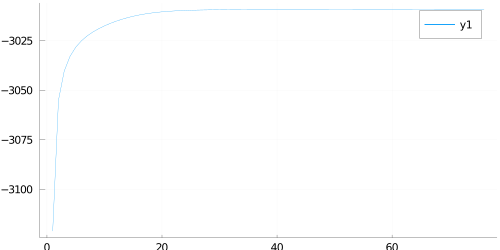

In [235]:
scalefontsizes(0.7)
plot(ll_tracker, size = (2000,1000))

In [186]:
pi_true

10-element Vector{Float64}:
 0.07486090994046252
 0.06630907995099644
 0.04635497490858906
 0.12989977210234596
 0.07946431674890926
 0.007701590683127249
 0.03216603198044118
 0.22843504422317773
 0.2659854323941368
 0.06882284706781369

In [187]:
pi_current

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.1569098690194622e-169
 1.0
 3.1287258841290735e-48

In [188]:
S

5000-element Vector{Int64}:
  9
  1
 10
 10
  1
  2
  8
  6
  5
  4
  4
  5
  7
  ⋮
  9
  3
  2
  3
  7
  2
  8
  4
  4
  2
  3
  7

In [189]:
A_current

10×10 Matrix{Float64}:
 0.0797933    0.0825862   0.0521364  …  0.0132636  0.149046   0.0893724
 0.0874546    0.00943367  0.101025      0.138385   0.128792   0.113128
 0.103687     0.0406885   0.0252767     0.0920819  0.0284695  0.115588
 3.08847e-12  0.149551    0.131459      0.113227   0.167295   0.0051757
 0.132121     0.0259526   0.117626      0.166128   0.0918149  0.0121483
 0.0290871    0.158582    0.0912045  …  0.111482   0.174667   0.0224593
 0.114325     0.0871184   0.183737      0.0112674  0.0878527  0.0182589
 0.143327     0.0208726   0.111665      0.160499   0.0682362  0.0657769
 0.188795     0.0117352   0.136843      0.0442518  0.0686848  0.162091
 0.106702     0.0939058   0.0412071     0.0522474  0.208223   0.175734

In [190]:
A_true

10×10 Matrix{Float64}:
 0.0752931   0.1341      0.0197698  …  0.0199917  0.116939   0.131136
 0.0850281   0.00812193  0.110777      0.140611   0.160813   0.102774
 0.118604    0.0305247   0.0441062     0.0406136  0.0577275  0.11217
 0.00860176  0.133947    0.124884      0.13774    0.108742   0.0446017
 0.114674    0.100397    0.0918971     0.131533   0.127359   0.0111749
 0.03043     0.148723    0.100613   …  0.0977629  0.14696    0.0136002
 0.0678053   0.0963498   0.161962      0.0260425  0.137581   0.0375044
 0.184826    0.00294772  0.125397      0.194892   0.0573867  0.0430482
 0.135083    0.00606615  0.176531      0.0378103  0.0582549  0.194518
 0.105152    0.0999984   0.0828344     0.0766694  0.173632   0.148507

In [146]:
delta_X_current

1000-element Vector{Float64}:
 -0.5
 -0.4999999999441931
  0.49999999997539746
 -0.49999999994243804
 -0.4999999999416129
  0.4999999999907052
  0.37283125462541733
  0.20954752013102595
 -0.4999999997454081
 -0.475819354317478
 -0.13718547656011637
  0.49999999992686384
 -0.49999999998159694
  ⋮
 -0.49999999993584776
  0.49999999983381377
  0.4999999999099376
  0.49999999996671196
  0.4999999999496172
 -0.4999999999848326
  0.4999999999292113
 -0.4999999998459712
 -0.49999999983840926
  0.49999999979654497
 -0.49999999993312727
 -0.4999999999748308

In [34]:
emission_dists[1]

Normal{Float64}(μ=0.0, σ=1.0)

In [35]:
pdf(emission_dists[1] , 0)

0.3989422804014327

In [44]:
size(X)

(1000,)

In [ ]:
alpha, ll = forward(hmm, X) ;

In [21]:
size(alpha)

(1000, 10)

In [23]:
beta, ll = backward(hmm, X) ;

In [45]:
ll

-2988.7376970659634

In [48]:
alpha[:,1]   ## alpha_i(t)

1000-element Vector{Float64}:
 1.377457231436896e-81
 4.161805708859276e-49
 3.8090138558900904e-6
 5.793994169528616e-6
 4.575338015676419e-36
 6.347222309512089e-23
 1.25351286810055e-30
 0.0002754733959509659
 1.8260445322767316e-33
 6.495740481473254e-60
 3.5647142938523994e-72
 5.980223983543251e-50
 1.5325873299343892e-21
 ⋮
 2.7964581224269716e-76
 0.8296444492575985
 0.8500411394751565
 1.9387499670240715e-36
 1.3336468166840385e-37
 2.82549404529659e-52
 2.5149956785875887e-6
 1.252345724615565e-68
 7.873496487021907e-67
 2.2042282599031384e-19
 1.736203783790174e-51
 3.0411507396722127e-25

In [54]:
t = 100 ; 
i =7 ;
alpha[t,i] # t is time and i is state

0.01048222993827342

In [56]:
size(X)

(1000,)

In [63]:
-(alpha[:,1]/(emission_dists[1].σ)^2)

1000-element Vector{Float64}:
 -1.377457231436896e-81
 -4.161805708859276e-49
 -3.8090138558900904e-6
 -5.793994169528616e-6
 -4.575338015676419e-36
 -6.347222309512089e-23
 -1.25351286810055e-30
 -0.0002754733959509659
 -1.8260445322767316e-33
 -6.495740481473254e-60
 -3.5647142938523994e-72
 -5.980223983543251e-50
 -1.5325873299343892e-21
  ⋮
 -2.7964581224269716e-76
 -0.8296444492575985
 -0.8500411394751565
 -1.9387499670240715e-36
 -1.3336468166840385e-37
 -2.82549404529659e-52
 -2.5149956785875887e-6
 -1.252345724615565e-68
 -7.873496487021907e-67
 -2.2042282599031384e-19
 -1.736203783790174e-51
 -3.0411507396722127e-25

In [100]:
istransmat(A_current)

false

In [73]:
X[1]

19.34658133078569

In [75]:
beta[1000,:]

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [81]:
#zeros((100,5,5))

In [97]:
alpha[1:size(X,1)-1,1]

999-element Vector{Float64}:
 1.377457231436896e-81
 4.161805708859276e-49
 3.8090138558900904e-6
 5.793994169528616e-6
 4.575338015676419e-36
 6.347222309512089e-23
 1.25351286810055e-30
 0.0002754733959509659
 1.8260445322767316e-33
 6.495740481473254e-60
 3.5647142938523994e-72
 5.980223983543251e-50
 1.5325873299343892e-21
 ⋮
 1.4533746943735298e-7
 2.7964581224269716e-76
 0.8296444492575985
 0.8500411394751565
 1.9387499670240715e-36
 1.3336468166840385e-37
 2.82549404529659e-52
 2.5149956785875887e-6
 1.252345724615565e-68
 7.873496487021907e-67
 2.2042282599031384e-19
 1.736203783790174e-51

In [109]:
sum(A_current)

0.5347665776267988

In [107]:
A_init

10×10 Matrix{Float64}:
 0.0795279  0.00347071  0.0354902  …  0.151362    0.0346173  0.104735
 0.121325   0.118636    0.0617576     0.0830787   0.0646036  0.174098
 0.113369   0.178874    0.0644956     0.0219382   0.0125377  0.0357513
 0.155039   0.0113916   0.142871      0.0935262   0.0833107  0.115447
 0.0283304  0.196831    0.132592      0.00673577  0.0240339  0.0368103
 0.042743   0.117246    0.0252563  …  0.206706    0.151543   0.0221061
 0.0956953  0.0117953   0.152679      0.0920463   0.128522   0.0288499
 0.107346   0.0612113   0.0332885     0.151732    0.0766395  0.107399
 0.164749   0.128843    0.0314618     0.124894    0.142672   0.0900314
 0.0102741  0.209016    0.0109105     0.134455    0.0906411  0.0383017

In [115]:
pi_current

10-element Vector{Float64}:
 2.923055726717785e-78
 9.807300973532004e-63
 3.882059267709648e-49
 1.9627059888836528e-36
 8.363064288677014e-27
 4.7242945097911497e-17
 8.68051579333805e-12
 8.02373656903226e-6
 0.042366105540417504
 0.9576258707143329

In [134]:
pi_init

10-element Vector{Float64}:
 0.02776948787878715
 0.04483331782318809
 0.11592816627607402
 0.12408001542162837
 0.10942361996274395
 0.2148602710321583
 0.010612418613146136
 0.06650466369730125
 0.19070509576016476
 0.09528294353480792

In [135]:
pi_current

10-element Vector{Float64}:
 2.923055726717785e-78
 9.807300973532004e-63
 3.882059267709648e-49
 1.9627059888836528e-36
 8.363064288677014e-27
 4.7242945097911497e-17
 8.68051579333805e-12
 8.02373656903226e-6
 0.042366105540417504
 0.9576258707143329

In [136]:
pi_true

10-element Vector{Float64}:
 0.07486090994046252
 0.06630907995099644
 0.04635497490858906
 0.12989977210234596
 0.07946431674890926
 0.007701590683127249
 0.03216603198044118
 0.22843504422317773
 0.2659854323941368
 0.06882284706781369

In [139]:
sum(A_current[1, :])

0.05778031088994036

In [140]:
sum(A_current)

0.5443935295739925

In [141]:
A_current

10×10 Matrix{Float64}:
 0.0064848   0.000408837  0.00151392   0.00689738  …  0.0016552   0.00379081
 0.00549587  0.00688335   0.00199861   0.0102736      0.00372526  0.00751445
 0.00317744  0.00599569   0.00217505   0.0101159      0.00056246  0.00211361
 0.004076    0.000366746  0.00675822   0.00170871     0.00553655  0.00485216
 0.00081229  0.0105977    0.00771863   0.00882518     0.00225569  0.000812684
 0.00128764  0.00602548   0.00121664   0.00577229  …  0.00933265  0.000332082
 0.00423233  0.000656373  0.00857637   0.00459661     0.0067704   0.000970133
 0.00490876  0.00295578   0.00269625   0.0105578      0.00321138  0.00336982
 0.00660477  0.00831033   0.00156184   0.00177681     0.00732456  0.00548455
 0.00055183  0.0122878    0.000270896  0.0133409      0.00688927  0.00208039

In [142]:
sum(pi_current)

1.0

In [143]:
delta_X_current

1000-element Vector{Float64}:
 -0.4999999999987521
 -0.4442782891895902
 -0.1079139278904222
  0.49999999987766763
 -0.1874073386981152
  0.21863079185389545
  0.32740434845935606
  0.2660946711976919
 -0.4999999999851976
 -0.492729835034857
 -0.43920866905970524
 -0.33575661552197467
  0.0953323653742677
  ⋮
 -0.49999999999260947
  0.49999999999878425
  0.18805520566595293
 -0.02966018562579187
 -0.13864339134466253
 -0.22505620284519257
  0.49999999997933475
 -0.12012812063514922
 -0.49999999999461675
  0.49999999996351896
 -0.44625026292834225
 -0.10596970679926887

In [144]:
sum(pi_current)

1.0